In [3]:
import sys
import os
import random
import pickle
import numpy as np
from preprocessing import make_delayed
from preprocessing import downsample_word_vectors
import torch
from transformers import BertTokenizerFast, BertModel
from embeddings import make_word_dict, make_word_embeddings

# Add the root project folder to sys.path (so ridge_utils becomes importable)
project_root = os.path.abspath('..')  # moves up from 'code/'
sys.path.append(project_root)

# Load the raw_text.pkl file
path_to_data = '../data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)


In [4]:
all_stories = list(raw_text.keys())
exclude = ['dialogue1',
 'dialogue2',
 'dialogue3',
 'dialogue4',
 'dialogue5',
 'dialogue6',
 'myfirstdaywiththeyankees',
 'onlyonewaytofindout']
valid_stories = [story for story in all_stories if story not in exclude]

In [5]:
all_stories = valid_stories
random.seed(42)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

print(f"Train stories: {len(train_stories)}")
print(f"Test stories: {len(test_stories)}")
train_stories.sort()
test_stories.sort()

Train stories: 70
Test stories: 31


DO FINE TUNING HERE!!!!!!! COPY file and rename!! also update the envrionment! using 
conda env update -f code/environment.yaml

In [6]:
# dictonaries for train stories
story_vectors_bert = {} 
story_vectors_bert = make_word_dict(train_stories, raw_text)

In [7]:
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_bert = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_bert,
    wordseqs=wordseqs
)
trimmed_vectors_bert = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_bert.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert[story] = trimmed_matrix

delayed_vectors_bert = {}

for story, trimmed_matrix in trimmed_vectors_bert.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert[story] = X_lagged

# check for first trimmed,delayed matrix, which corresponds to first story
for key, value in delayed_vectors_bert.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break

First key: adollshouse
delayed matrix for first story is (241, 3072)


In [8]:
# dictionaries for test stories
story_vectors_bert_test = {}
story_vectors_bert_test = make_word_dict(test_stories, raw_text)

In [9]:
wordseqs2 = {story: raw_text[story] for story in test_stories}
downsampled_vectors_bert_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_bert_test,
    wordseqs=wordseqs2
)
trimmed_vectors_bert_test = {} #trimmed matrices for each test story 
for story, matrix in downsampled_vectors_bert_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_bert_test[story] = trimmed_matrix

delayed_vectors_bert_test = {}
for story, trimmed_matrix in trimmed_vectors_bert_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_bert_test[story] = X_lagged
print(len(delayed_vectors_bert_test))

31


In [10]:
import gc
del raw_text
gc.collect()

485

Ridge Regression - subject 2

In [11]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

In [12]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

In [13]:
#Test for bert, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_bert[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_bert_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

In [14]:
logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

In [15]:
# when alphas are all 1.
#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.010363654864144402


CV - 5 fold

In [16]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for bert")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19290, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2066.908
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00899, max corr=0.13314, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00960, max corr=0.13869, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01115, max corr=0.15646, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01399, max corr=0.17950, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01792, max corr=0.19432, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02152, max corr=0.18976, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02242, max corr=0.17238, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02091, max corr=0.15973, over-und

Processing fold 2/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18621, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2056.302
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00789, max corr=0.11167, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00863, max corr=0.11572, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01052, max corr=0.12545, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01370, max corr=0.14704, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01774, max corr=0.17003, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02114, max corr=0.17447, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02116, max corr=0.16485, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01901, max corr=0.15594, over-und

Processing fold 3/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19016, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2046.363
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00697, max corr=0.12030, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00784, max corr=0.12386, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01015, max corr=0.13099, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01371, max corr=0.13904, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01721, max corr=0.14600, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02009, max corr=0.14900, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02087, max corr=0.14126, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01985, max corr=0.13715, over-und

Processing fold 4/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19124, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2072.220
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00694, max corr=0.12218, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00769, max corr=0.12816, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00963, max corr=0.13827, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01316, max corr=0.15702, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01787, max corr=0.17585, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02215, max corr=0.17399, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02323, max corr=0.14730, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02157, max corr=0.13474, over-und

Processing fold 5/5 for bert


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19189, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2079.215
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00796, max corr=0.13868, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00880, max corr=0.14362, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01110, max corr=0.15918, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01492, max corr=0.18379, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01943, max corr=0.20284, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02328, max corr=0.20567, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02367, max corr=0.19447, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02149, max corr=0.18410, over-under

In [17]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (bert): {mean_cc_s2}")
print(f"Median test CC for subject 2 (bert): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (bert): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (bert): {top_5_percentile_cc_s2}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (bert): 0.024577067947916205
Median test CC for subject 2 (bert): 0.019193762017285752
Top 1 percentile test CC for subject 2 (bert): 0.10932682557503179
Top 5 percentile test CC for subject 2 (bert): 0.0748373350238138


In [18]:
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

2900

subject 3

In [19]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

In [20]:
#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

Fit Ridge with alphas 1

In [21]:
#subject3
num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean CC for sub3: 0.015787619434160335


CV - 5 fold

In [22]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for w2v (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_bert[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_bert[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19290, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2066.908
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01559, max corr=0.16965, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01677, max corr=0.17671, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01952, max corr=0.19339, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02356, max corr=0.21323, over-under(0.20)=11
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02817, max corr=0.21663, over-under(0.20)=25
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03160, max corr=0.21069, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03040, max corr=0.19262, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02710, max corr=0.17163, over-u

Processing fold 2/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18621, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2056.302
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01393, max corr=0.16878, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01513, max corr=0.17718, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01812, max corr=0.19478, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02290, max corr=0.21277, over-under(0.20)=2
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02824, max corr=0.21974, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03282, max corr=0.21513, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03341, max corr=0.19251, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03094, max corr=0.17535, over-und

Processing fold 3/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19016, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2046.363
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01349, max corr=0.15723, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01469, max corr=0.16346, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01785, max corr=0.17822, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02286, max corr=0.19916, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02815, max corr=0.21318, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03206, max corr=0.21580, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03167, max corr=0.19555, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02852, max corr=0.17791, over-und

Processing fold 4/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19124, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2072.220
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01609, max corr=0.16615, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01711, max corr=0.17429, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01972, max corr=0.19374, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02421, max corr=0.22225, over-under(0.20)=9
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02954, max corr=0.24159, over-under(0.20)=26
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03388, max corr=0.23779, over-under(0.20)=24
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03426, max corr=0.21453, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03154, max corr=0.18801, over-

Processing fold 5/5 for w2v (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19189, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2079.215
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01643, max corr=0.22127, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01778, max corr=0.23011, over-under(0.20)=5
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02107, max corr=0.24843, over-under(0.20)=15
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.02605, max corr=0.26745, over-under(0.20)=79
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03147, max corr=0.27085, over-under(0.20)=143
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.03554, max corr=0.26311, over-under(0.20)=108
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.03494, max corr=0.24751, over-under(0.20)=27
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.03143, max corr=0.22307, o

In [23]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (bert): {mean_cc_s3}")
print(f"Median test CC for subject 3 (bert): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (bert): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (bert): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23810, 3072))
INFO:ridge_corr:Training stimulus has LSV norm: 2306.696
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3 (bert): 0.033298118675260606
Median test CC for subject 3 (bert): 0.026339561982116247
Top 1 percentile test CC for subject 3 (bert): 0.1372150348480857
Top 5 percentile test CC for subject 3 (bert): 0.09454526857708022


Draw CC distribution

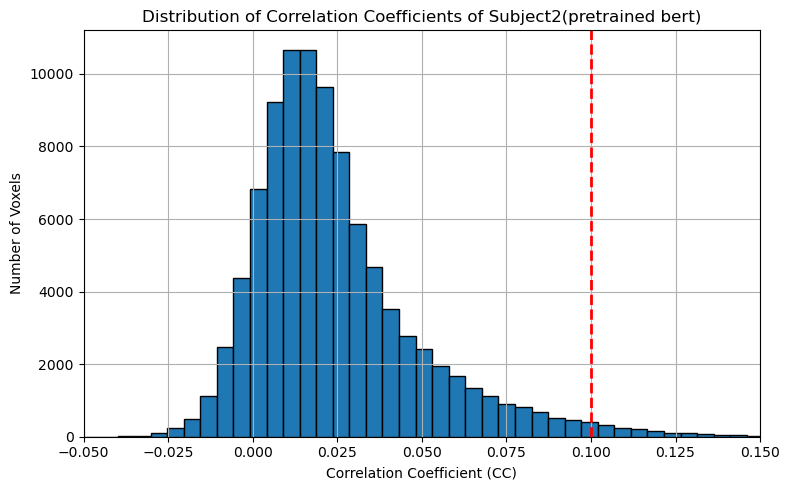

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(pretrained bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
plt.savefig("../figs/ccdist_pretrainbert_2.png", dpi=300)
plt.tight_layout()
plt.show()

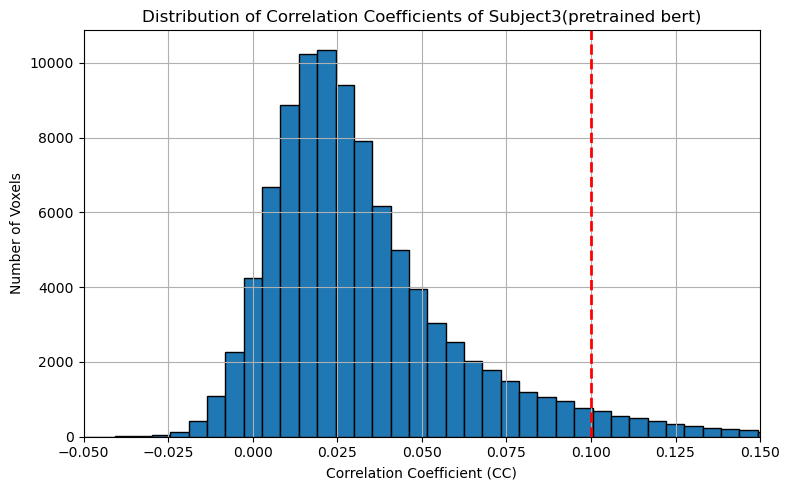

In [26]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(pretrained bert)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.xlim(-0.05, 0.15)
plt.axvline(x=0.1, color='red', linestyle='--', linewidth=2)
plt.savefig("../figs/ccdist_pretrainbert_3.png", dpi=300)
plt.tight_layout()
plt.show()